In [1]:
import os
from itertools import product

from tqdm import tqdm_notebook as tqdm
import glob
import numpy as np
import pandas as pd
import math

In [2]:
from functools import reduce
from sklearn.metrics import roc_auc_score
from sklearn.externals import joblib

def multi_roc_auc_score(y_true, y_pred):
    assert y_true.shape == y_pred.shape
    columns = y_true.shape[1]
    column_losses = []
    for i in range(0, columns):
        column_losses.append(roc_auc_score(y_true[:, i], y_pred[:, i]))
    return np.array(column_losses).mean()

def read_predictions(prediction_dir, concat_mode='concat', per_label=False):
    labels = pd.read_csv(os.path.join(prediction_dir, 'labels.csv'))

    filepaths_train, filepaths_test = [], []
    for filepath in sorted(glob.glob('{}/*'.format(prediction_dir))):
        if filepath.endswith('predictions_train_oof.csv'):
            filepaths_train.append(filepath)
        elif filepath.endswith('predictions_test_oof.csv'):
            filepaths_test.append(filepath)

    train_dfs = []
    for filepath in filepaths_train:
        train_dfs.append(pd.read_csv(filepath))
    train_dfs = reduce(lambda df1, df2: pd.merge(df1, df2, on=['id', 'fold_id']), train_dfs)
    train_dfs.columns = _clean_columns(train_dfs, keep_colnames = ['id','fold_id'])
    train_dfs = pd.merge(train_dfs, labels, on=['id'])

    test_dfs = []
    for filepath in filepaths_test:
        test_dfs.append(pd.read_csv(filepath))
    test_dfs = reduce(lambda df1, df2: pd.merge(df1, df2, on=['id', 'fold_id']), test_dfs)
    test_dfs.columns = _clean_columns(test_dfs, keep_colnames = ['id','fold_id'])

    return train_dfs, test_dfs

def _clean_columns(df, keep_colnames):
    new_colnames = []
    for i,colname in enumerate(df.columns):
        if colname not in keep_colnames:
            new_colnames.append(i)
        else:
            new_colnames.append(colname)
    return new_colnames

def logit(p):
    return np.log(p) - np.log(1 - p)

def get_fold_xy(train, test, label_columns,i):
    train_split = train[train['fold_id'] != i]
    valid_split = train[train['fold_id'] == i]
    test_split = test[test['fold_id'] == i]

    y_train = train_split[label_columns].values
    y_valid = valid_split[label_columns].values
    columns_to_drop_train = label_columns + ['id','fold_id']
    X_train = train_split.drop(columns_to_drop_train, axis=1).values
    X_valid = valid_split.drop(columns_to_drop_train, axis=1).values

    columns_to_drop_test = ['id','fold_id']
    X_test = test_split.drop(columns_to_drop_test, axis=1).values
    return (X_train, y_train), (X_valid, y_valid), X_test
    

def stack_per_label(X, label_nr=6):
    n,k =X.shape
    model_nr = int(k/label_nr)
    X_ = []
    for i in range(model_nr):
        X_.append(X[:,i*label_nr:(i+1)*label_nr])
    X_ = np.stack(X_, axis=-1)
    return X_

def get_model_names(prediction_dir):
    suffix = '_predictions_test_oof.csv'
    filepaths = sorted([path.replace(suffix,'') for path in os.listdir(prediction_dir) if suffix in path])
    return filepaths

In [8]:
LABEL_COLUMNS = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

SINGLE_DIR = '~/data/toxic_nep/predictions/single_model_predictions_000'
SINGLE_DIR = os.path.expanduser(SINGLE_DIR)
assert os.path.exists(SINGLE_DIR), SINGLE_DIR

In [9]:
train, test = read_predictions(SINGLE_DIR)

In [10]:
model_names = get_model_names(SINGLE_DIR)

for i, model_name in enumerate(model_names):
    print(i, model_name)

0 bad_word_logreg
1 count_logreg
2 tfidf_logreg


# Let's explore the label distributions and model correlations

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

(X_train, y_train), (X_valid, y_valid), X_test = get_fold_xy(train, test, LABEL_COLUMNS,0)
X_train_per_label = stack_per_label(X_train)

In [12]:
for i, label in enumerate(LABEL_COLUMNS):
    target_values = y_train[:,i]
    mean_target = np.mean(target_values)
    print(label, mean_target, int(1/mean_target))

toxic 0.09584090576758371 10
severe_toxic 0.009978205315674765 100
obscene 0.052808589751624155 18
threat 0.003015047384289723 331
insult 0.0493896792073141 20
identity_hate 0.008850173730790388 112


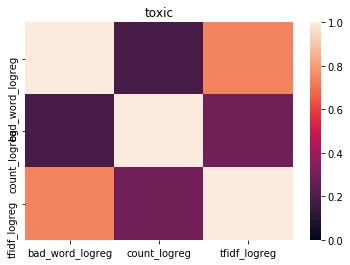

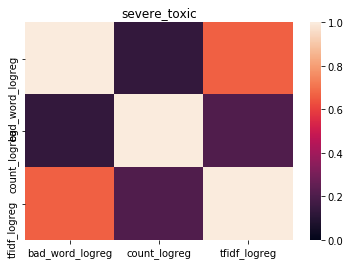

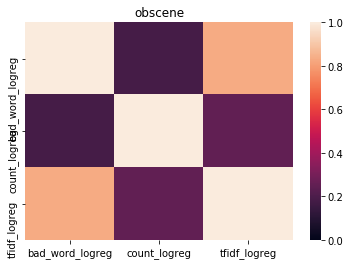

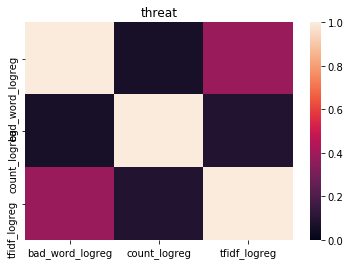

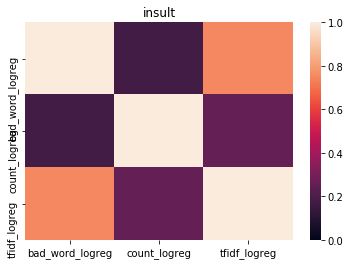

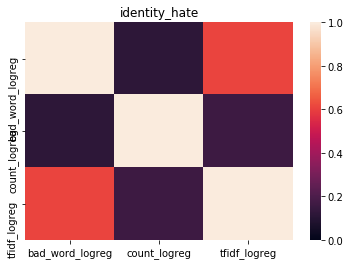

In [13]:
for i, label in enumerate(LABEL_COLUMNS):
    label_predictions = pd.DataFrame(X_train_per_label[:,i,:],columns = model_names)
    correlation_mat = label_predictions.corr()
    plt.title(label)
    sns.heatmap(correlation_mat, vmin=0.0, vmax=1.0)
    plt.show()

# Per-label Model

# Ensemble Training

In [14]:
def fit_cv(estimator, params, train, test, label_id, n_splits=10):
    estimators,scores, test_predictions = [],[],[]   
    for i in range(n_splits):
        (X_train, y_train), (X_valid, y_valid), X_test = get_fold_xy(train, test, LABEL_COLUMNS,i)

        y_train = y_train[:,label_id]
        y_valid = y_valid[:,label_id]
        
        estimator_ = estimator(**params) 
        estimator_.fit(X_train, y_train,
                       early_stopping_rounds=10,
                       eval_metric=['error','auc'],
                       eval_set=[(X_train, y_train), (X_valid, y_valid)],
                      verbose=False)        
        y_valid_pred = estimator_.predict_proba(X_valid, ntree_limit=estimator_.best_ntree_limit)[:,1]
        y_test_pred = estimator_.predict_proba(X_test, ntree_limit=estimator_.best_ntree_limit)[:,1]
        score = roc_auc_score(y_valid, y_valid_pred)
        estimators.append(estimator_)
        scores.append(score)
        test_predictions.append(y_test_pred)
    return scores, estimators, test_predictions   

def make_grid(param_grid):
    keys, values = zip(*param_grid.items())
    param_dicts = [dict(zip(keys, v)) for v in product(*values)]
    return param_dicts

def plot_xgboost_learning_curve(model):
    results = model.evals_result()
    epochs = len(results['validation_0']['error'])
    x_axis = range(0, epochs)

    fig, [ax1,ax2] = plt.subplots(1,2, figsize=(14,6))
    ax1.plot(x_axis, results['validation_0']['error'], label='Train')
    ax1.plot(x_axis, results['validation_1']['error'], label='Test')
    ax1.legend()
    ax1.set_title('XGBoost Log Loss')
    
    ax2.plot(x_axis, results['validation_0']['auc'], label='Train')
    ax2.plot(x_axis, results['validation_1']['auc'], label='Test')
    ax2.legend()
    ax2.set_title('XGBoost AUC')
    plt.show()

In [15]:
valid_scores, predictions_test = {}, {}

# Toxic

The default model

```python
estimator = XGBClassifier

params = dict(objective= 'rank:pairwise',
                  eval_metric= 'auc',
                  scale_pos_weight = 10,
                  n_estimators= 500,
                  learning_rate= 0.1,
                  max_depth= 4,
                  min_child_weight= 7,
                  gamma=0.01,
                  subsample= 1.0,
                  colsample_bytree= 0.8, 
                  reg_lambda= 0.1, #1.0
                  reg_alpha= 0.0,
                  n_jobs=12
                 )

```

gets **0.98704**  10-fold CV

## Grid Search

In [ ]:
from xgboost import XGBClassifier

estimator = XGBClassifier
      
param_grid = dict(objective= ['rank:pairwise'],
                  eval_metric= ['auc'],
                  scale_pos_weight = [100],
                  n_estimators= [500],
                  learning_rate= [0.1],
                  max_depth= [2,3,4,5],
                  min_child_weight= [1,3,5,7],
                  gamma=[0.01,0.05,0.1,0.5],
                  subsample= [1.0,0.8,0.6],
                  colsample_bytree= [0.4,0.6,0.8,1.0], 
                  reg_lambda= [0.0,0.01,0.1,0.5,1.0], #1.0
                  reg_alpha= [0.0],
                  n_jobs=[12]
                 )

label_id = 0
nr_runs = 50
grid_sample = np.random.choice(make_grid(param_grid), nr_runs, replace=False)

grid_scores = []
for params in tqdm(grid_sample):
    scores, estimators, test_prediction = fit_cv(estimator, params, train, test, label_id, n_splits=10)  
#     plot_xgboost_learning_curve(estimators[-1])
#     print(params)
    print('mean {} std {}'.format(np.mean(scores), np.std(scores)))
    grid_scores.append((params, np.mean(scores)))
    
best_params = sorted(grid_scores, key= lambda x: x[1])[-1]
print(best_params)

HBox(children=(IntProgress(value=0, max=50), HTML(value='')))

mean 0.9813226226333592 std 0.00214807807785802
mean 0.9810582750532104 std 0.0020302749934601313
mean 0.9810276530758312 std 0.0020304348870934952
mean 0.9811646419866895 std 0.002123061371045187
mean 0.9812708632041567 std 0.0020565312028081586
mean 0.981277563217804 std 0.0020830954124503643
mean 0.9792431956303547 std 0.002479071393495923
mean 0.9810534601371517 std 0.0020661331403151674
mean 0.9794958105532434 std 0.002336835741438121
mean 0.9788625265902666 std 0.0031652307355162185
mean 0.9811242254400685 std 0.002075417361384119
mean 0.9811630601396084 std 0.0020366356355593536
mean 0.9781993658822076 std 0.0021568109535513697
mean 0.9810775515536634 std 0.0020216125182992797
mean 0.9811320611720543 std 0.0020933183990567306
mean 0.9782086477352829 std 0.0021612470782795446
mean 0.9775319260156028 std 0.0016036336630716064
mean 0.9811330317205762 std 0.002177306831589471
mean 0.9811102223302534 std 0.0020471481891956686
mean 0.9812247070589901 std 0.0021049375096654495
mean 0.9

## Fit best estimator

In [ ]:
from xgboost import XGBClassifier

estimator = XGBClassifier

label_id = 0

scores, estimators, test_prediction = fit_cv(estimator, best_params[0], train, test, label_id, n_splits=10)  
valid_scores['toxic'] = scores
predictions_test['toxic'] = test_prediction
plot_xgboost_learning_curve(estimators[-1])
print(params)
print('mean {} std {}'.format(np.mean(scores), np.std(scores)))

# Severe Toxic

The default model

```python
estimator = XGBClassifier
    
params = dict(objective= 'binary:logistic',
  eval_metric= 'auc',
  n_estimators= 125,
  learning_rate= 0.1,
  max_depth= 3,
  min_child_weight= 10,
  gamma=0.0,
  subsample= 0.8,
  colsample_bytree= 0.45, #0.3-0.5
  reg_lambda= 0.2, #0.05
  reg_alpha= 0.0,
  n_jobs=12)

```

gets **0.99113**  10-fold CV

## Grid Search

In [ ]:
estimator = XGBClassifier
    
param_grid = dict(objective= ['rank:pairwise'],
                  eval_metric= ['auc'],
                  scale_pos_weight = [100],
                  n_estimators= [500],
                  learning_rate= [0.1],
                  max_depth= [2,3,4,5],
                  min_child_weight= [1,3,5,7],
                  gamma=[0.01,0.05,0.1,0.5],
                  subsample= [1.0,0.8,0.6],
                  colsample_bytree= [0.4,0.6,0.8,1.0], 
                  reg_lambda= [0.0,0.01,0.1,0.5,1.0], #1.0
                  reg_alpha= [0.0],
                  n_jobs=[12]
                 )

label_id = 1

nr_runs = 50
grid_sample = np.random.choice(make_grid(param_grid), nr_runs, replace=False)

grid_scores = []
for params in tqdm(grid_sample):
    scores, estimators, test_prediction = fit_cv(estimator, params, train, test, label_id, n_splits=10)  
#     plot_xgboost_learning_curve(estimators[-1])
#     print(params)
    print('mean {} std {}'.format(np.mean(scores), np.std(scores)))
    grid_scores.append((params, np.mean(scores)))
    
best_params = sorted(grid_scores, key= lambda x: x[1])[-1]
print(best_params)

## Fit Best

In [ ]:
label_id = 1

scores, estimators, test_prediction = fit_cv(estimator, best_params[0], train, test, label_id, n_splits=10)  
valid_scores['severe_toxic'] = scores
predictions_test['severe_toxic'] = test_prediction
plot_xgboost_learning_curve(estimators[-1])
print(params)
print('mean {} std {}'.format(np.mean(scores), np.std(scores)))

# Obscene

The default model

```python
estimator = XGBClassifier
    
params = dict(objective= 'binary:logistic',
  eval_metric= 'auc',
  n_estimators= 125,
  learning_rate= 0.1,
  max_depth= 3,
  min_child_weight= 10,
  gamma=0.0,
  subsample= 0.8,
  colsample_bytree= 0.45, #0.3-0.5
  reg_lambda= 0.2, #0.05
  reg_alpha= 0.0,
  n_jobs=12)

```

gets **0.99501**  10-fold CV

In [ ]:
estimator = XGBClassifier
    
param_grid = dict(objective= ['rank:pairwise'],
                  eval_metric= ['auc'],
                  scale_pos_weight = [18],
                  n_estimators= [500],
                  learning_rate= [0.1],
                  max_depth= [2,3,4,5],
                  min_child_weight= [1,3,5,7],
                  gamma=[0.01,0.05,0.1,0.5],
                  subsample= [1.0,0.8,0.6],
                  colsample_bytree= [0.4,0.6,0.8,1.0], 
                  reg_lambda= [0.0,0.01,0.1,0.5,1.0], #1.0
                  reg_alpha= [0.0],
                  n_jobs=[12]
                 )

label_id = 2

nr_runs = 50
grid_sample = np.random.choice(make_grid(param_grid), nr_runs, replace=False)

grid_scores = []
for params in tqdm(grid_sample):
    scores, estimators, test_prediction = fit_cv(estimator, params, train, test, label_id, n_splits=10)  
#     plot_xgboost_learning_curve(estimators[-1])
#     print(params)
    print('mean {} std {}'.format(np.mean(scores), np.std(scores)))
    grid_scores.append((params, np.mean(scores)))
    
best_params = sorted(grid_scores, key= lambda x: x[1])[-1]
print(best_params)

## Fit Best

In [ ]:
label_id = 2

scores, estimators, test_prediction = fit_cv(estimator, best_params[0], train, test, label_id, n_splits=10)  
valid_scores['obscene'] = scores
predictions_test['obscene'] = test_prediction
plot_xgboost_learning_curve(estimators[-1])
print(params)
print('mean {} std {}'.format(np.mean(scores), np.std(scores)))

# Threat

The default model

```python
estimator = XGBClassifier
    
params = dict(objective= 'binary:logistic',
  eval_metric= 'auc',
  n_estimators= 125,
  learning_rate= 0.1,
  max_depth= 3,
  min_child_weight= 10,
  gamma=0.0,
  subsample= 0.8,
  colsample_bytree= 0.45, #0.3-0.5
  reg_lambda= 0.2, #0.05
  reg_alpha= 0.0,
  n_jobs=12)

```

gets **0.99296**  10-fold CV

In [ ]:
estimator = XGBClassifier
    
param_grid = dict(objective= ['rank:pairwise'],
                  eval_metric= ['auc'],
                  scale_pos_weight = [331],
                  n_estimators= [500],
                  learning_rate= [0.1],
                  max_depth= [2,3,4,5],
                  min_child_weight= [1,3,5,7],
                  gamma=[0.01,0.05,0.1,0.5],
                  subsample= [1.0,0.8,0.6],
                  colsample_bytree= [0.4,0.6,0.8,1.0], 
                  reg_lambda= [0.0,0.01,0.1,0.5,1.0], #1.0
                  reg_alpha= [0.0],
                  n_jobs=[12]
                 )

label_id = 3

nr_runs = 50
grid_sample = np.random.choice(make_grid(param_grid), nr_runs, replace=False)

grid_scores = []
for params in tqdm(grid_sample):
    scores, estimators, test_prediction = fit_cv(estimator, params, train, test, label_id, n_splits=10)  
#     plot_xgboost_learning_curve(estimators[-1])
#     print(params)
    print('mean {} std {}'.format(np.mean(scores), np.std(scores)))
    grid_scores.append((params, np.mean(scores)))
    
best_params = sorted(grid_scores, key= lambda x: x[1])[-1]
print(best_params)

In [ ]:
label_id = 3

scores, estimators, test_prediction = fit_cv(estimator, best_params[0], train, test, label_id, n_splits=10)  
valid_scores['threat'] = scores
predictions_test['threat'] = test_prediction
plot_xgboost_learning_curve(estimators[-1])
print(params)
print('mean {} std {}'.format(np.mean(scores), np.std(scores)))

# Insult

The default model

```python
estimator = XGBClassifier
    
params = dict(objective= 'binary:logistic',
  eval_metric= 'auc',
  n_estimators= 125,
  learning_rate= 0.1,
  max_depth= 3,
  min_child_weight= 10,
  gamma=0.0,
  subsample= 0.8,
  colsample_bytree= 0.45, #0.3-0.5
  reg_lambda= 0.2, #0.05
  reg_alpha= 0.0,
  n_jobs=12)

```

gets **0.989208**  10-fold CV

In [ ]:
estimator = XGBClassifier
    
param_grid = dict(objective= ['rank:pairwise'],
                  eval_metric= ['auc'],
                  scale_pos_weight = [20],
                  n_estimators= [500],
                  learning_rate= [0.1],
                  max_depth= [2,3,4,5],
                  min_child_weight= [1,3,5,7],
                  gamma=[0.01,0.05,0.1,0.5],
                  subsample= [1.0,0.8,0.6],
                  colsample_bytree= [0.4,0.6,0.8,1.0], 
                  reg_lambda= [0.0,0.01,0.1,0.5,1.0], #1.0
                  reg_alpha= [0.0],
                  n_jobs=[12]
                 )

label_id = 4

nr_runs = 50
grid_sample = np.random.choice(make_grid(param_grid), nr_runs, replace=False)

grid_scores = []
for params in tqdm(grid_sample):
    scores, estimators, test_prediction = fit_cv(estimator, params, train, test, label_id, n_splits=10)  
#     plot_xgboost_learning_curve(estimators[-1])
    print(params)
    print('mean {} std {}'.format(np.mean(scores), np.std(scores)))
    grid_scores.append((params, np.mean(scores)))
    
best_params = sorted(grid_scores, key= lambda x: x[1])[-1]
print(best_params)

In [ ]:
label_id = 4

scores, estimators, test_prediction = fit_cv(estimator, best_params[0], train, test, label_id, n_splits=10)  
valid_scores['insult'] = scores
predictions_test['insult'] = test_prediction
plot_xgboost_learning_curve(estimators[-1])
print(params)
print('mean {} std {}'.format(np.mean(scores), np.std(scores)))

# Identity Hate

The default model

```python
estimator = XGBClassifier
    
params = dict(objective= 'binary:logistic',
  eval_metric= 'auc',
  n_estimators= 125,
  learning_rate= 0.1,
  max_depth= 3,
  min_child_weight= 10,
  gamma=0.0,
  subsample= 0.8,
  colsample_bytree= 0.45, #0.3-0.5
  reg_lambda= 0.2, #0.05
  reg_alpha= 0.0,
  n_jobs=12)

```

gets **0.990216**  10-fold CV

In [ ]:
estimator = XGBClassifier
    
param_grid = dict(objective= ['rank:pairwise'],
                  eval_metric= ['auc'],
                  scale_pos_weight = [112],
                  n_estimators= [500],
                  learning_rate= [0.1],
                  max_depth= [2,3,4,5],
                  min_child_weight= [1,3,5,7],
                  gamma=[0.01,0.05,0.1,0.5],
                  subsample= [1.0,0.8,0.6],
                  colsample_bytree= [0.4,0.6,0.8,1.0], 
                  reg_lambda= [0.0,0.01,0.1,0.5,1.0], #1.0
                  reg_alpha= [0.0],
                  n_jobs=[12]
                 )

label_id = 5

nr_runs = 50
grid_sample = np.random.choice(make_grid(param_grid), nr_runs, replace=False)

grid_scores = []
for params in tqdm(grid_sample):
    scores, estimators, test_prediction = fit_cv(estimator, params, train, test, label_id, n_splits=10)  
#     plot_xgboost_learning_curve(estimators[-1])
#     print(params)
    print('mean {} std {}'.format(np.mean(scores), np.std(scores)))
    grid_scores.append((params, np.mean(scores)))
    
best_params = sorted(grid_scores, key= lambda x: x[1])[-1]
print(best_params)

In [ ]:
label_id = 5

scores, estimators, test_prediction = fit_cv(estimator, best_params[0], train, test, label_id, n_splits=10)  
valid_scores['identity_hate'] = scores
predictions_test['identity_hate'] = test_prediction
plot_xgboost_learning_curve(estimators[-1])
print(params)
print('mean {} std {}'.format(np.mean(scores), np.std(scores)))

# Combine

In [ ]:
final_cv_score = []
for label, scores in valid_scores.items():
    final_cv_score.append(np.mean(scores))
    print(label, np.mean(scores),np.std(scores))
print(np.mean(final_cv_score))

# Lets explore out of fold predictions as explained here 

https://www.kaggle.com/ogrellier/things-you-need-to-be-aware-of-before-stacking

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook

for l, label in enumerate(LABEL_COLUMNS):
    predictions = predictions_test[label]
    for fold_predictions in predictions:
#         fold_predictions_logit = np.log((fold_predictions + 1e-5) / (1 - fold_predictions + 1e-5))
#         sns.distplot(fold_predictions_logit, hist=False)
        sns.distplot(fold_predictions, hist=False)
    plt.title(label)
    plt.show()

# Olivier's (kaggle kernel) ranking can be applied to out of fold predictions

In [ ]:
def oof_scaling(predictions):
    predictions = pd.DataFrame(predictions)
    predictions = (1 + predictions.rank().values) / (predictions.shape[0] + 1)
    return predictions

In [ ]:
for l, label in enumerate(LABEL_COLUMNS):
    predictions = predictions_test[label]
    for fold_predictions in predictions:
        fold_predictions = oof_scaling(fold_predictions)
#         fold_predictions_logit = np.log((fold_predictions + 1e-5) / (1 - fold_predictions + 1e-5))
#         sns.distplot(predictions_logit, hist=False)
        sns.distplot(fold_predictions, hist=False)
    plt.title(label)
    plt.show()

In [ ]:
combined_predictions = {}
for label, predictions in predictions_test.items():
    oof_predictions = [oof_scaling(fold_predictions) for fold_predictions in predictions]
    oof_predictions_mean = np.mean(np.stack(oof_predictions, axis=-1),axis=-1).reshape(-1)
    combined_predictions[label] = oof_predictions_mean.tolist()
combined_predictions = pd.DataFrame(combined_predictions)

In [ ]:
combined_predictions.head()

In [ ]:
ENSEMBLE_SUBMISSION_PATH = '/output/xgboost_submission.csv'

submission = pd.read_csv('/public/toxic_comments/single_model_predictions_03092018/sample_submission.csv')
submission[LABEL_COLUMNS] = combined_predictions[LABEL_COLUMNS].values 
submission.to_csv(ENSEMBLE_SUBMISSION_PATH, index=None)
submission.head()